In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

import scienceplots
plt.style.use(['science', 'no-latex', 'light'])

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models/"

In [2]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
1,pretrained_mamba,decision_tree,decision_tree_mamba,depth=4,-1,-1,20,24,0,decision_tree_mamba
0,pretrained_no_pos,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_no_pos
2,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained
11,pretrained_mamba,linear_regression,linear_regression_mamba,,-1,-1,20,24,0,linear_regression_mamba
14,pretrained_new_more,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_more
10,pretrained_no_pos,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_no_pos
13,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained
12,pretrained_new,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_standard
4,pretrained_mamba,relu_2nn_regression,relu_2nn_regression_mamba,hidden_layer_size=100,-1,-1,20,24,0,relu_2nn_regression_mamba
3,pretrained_no_pos,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_no_pos


# Plot pre-computed metrics

linear_regression_mamba pretrained_mamba


100%|██████████| 15/15 [00:00<00:00, 223895.23it/s]


linear_regression_more pretrained_new_more


100%|██████████| 15/15 [00:00<00:00, 242913.36it/s]


<Figure size 2000x1200 with 0 Axes>

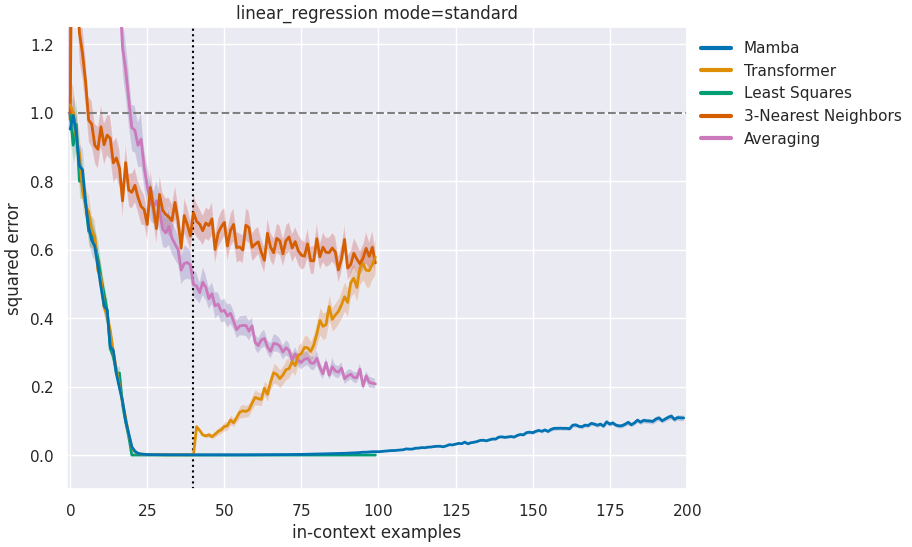

In [32]:
 # these are normally precomputed at the end of training
for task in (
    "linear_regression",
    # "sparse_linear_regression",
    # "decision_tree",
    # "relu_2nn_regression",
):

    run_ids = (
        "pretrained_mamba",
        # "pretrained", 
        # "pretrained_new",
        "pretrained_no_pos",
        # "pretrained_new_more",
        )  

    for run_id in run_ids:
        run_path = os.path.join(run_dir, task, run_id)
        recompute_metrics = False

        if recompute_metrics:
            get_run_metrics(run_path) 


    xlim = 200
    # xlim = 100
    # xlim = None

    def valid_row(r):
        return r.task == task and r.run_id in run_ids

    def rename_mamba(x, r):
        return x if 'mamba' not in x else 'Mamba'

    metrics = collect_results(run_dir, df, valid_row=valid_row, rename_model=rename_mamba,
                              no_recompute=True, xlim=xlim)
    _, conf = get_model_from_run(run_path, only_conf=True)
    n_dims = conf.model.n_dims
    n_train_points = conf.training.curriculum.points.end



    models = relevant_model_names[task].copy()
    # models.remove('Mamba')
    # models.remove('Transformer')

    plt.figure(figsize=(20, 12))     
    basic_plot(metrics["standard"], models=models, title=f"{task} mode=standard", n_train_points=n_train_points,
               size_mult=2.)
    # plt.savefig(f"../imgs/no_pos/{task}.png")
    plt.show()

In [12]:
metrics.keys()

dict_keys(['linear_regression', 'standard'])

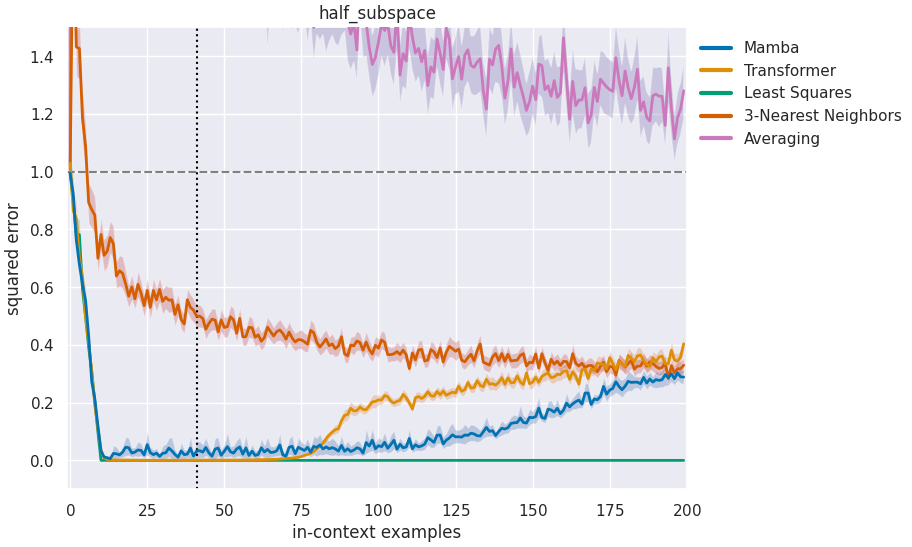

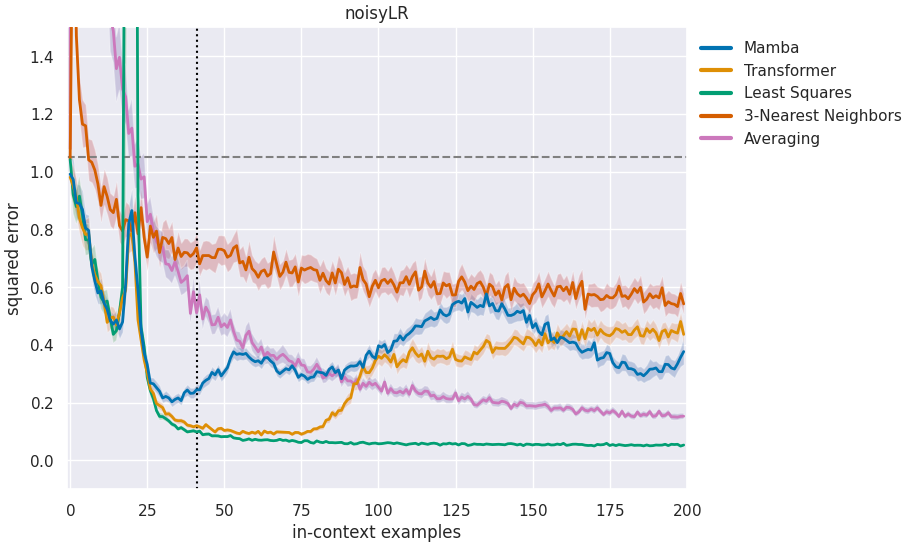

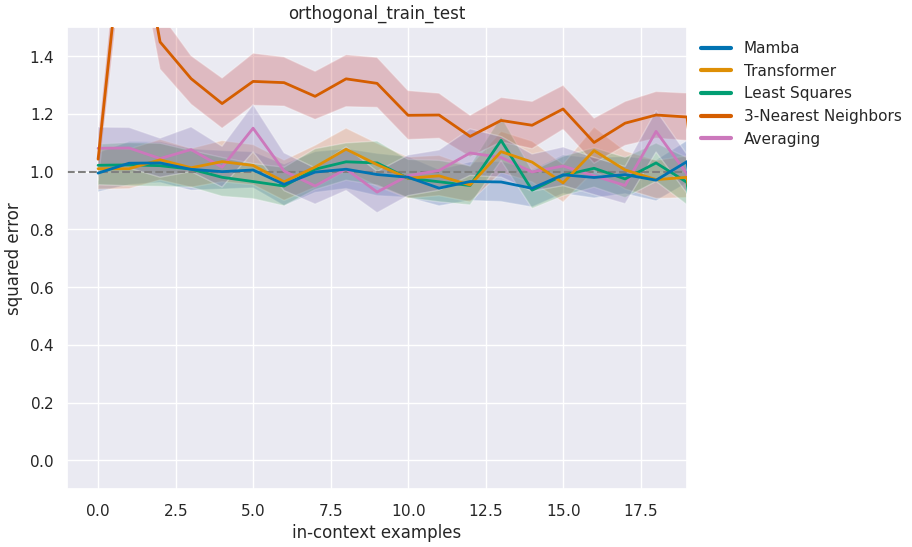

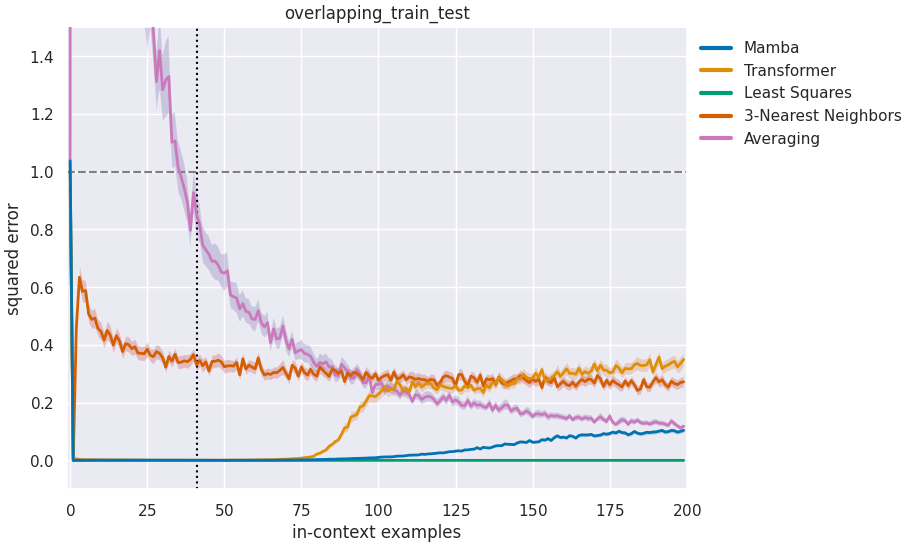

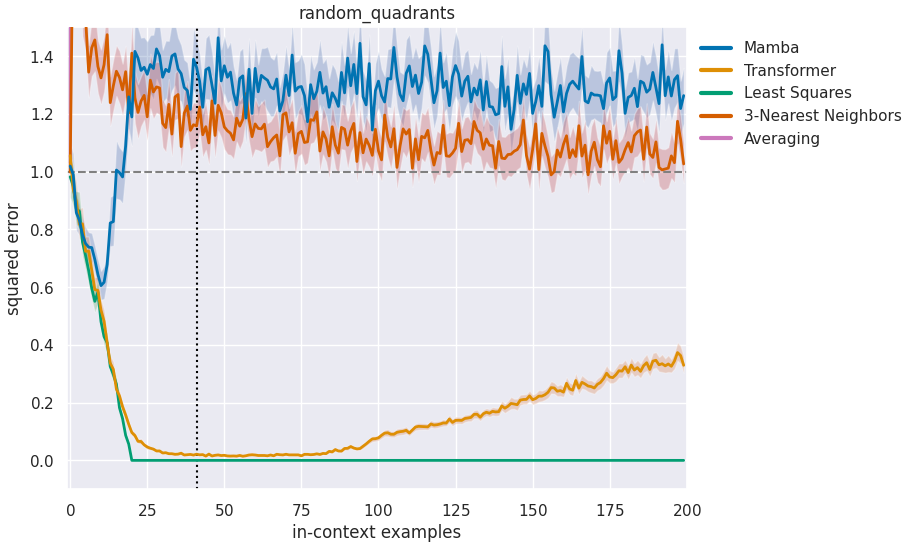

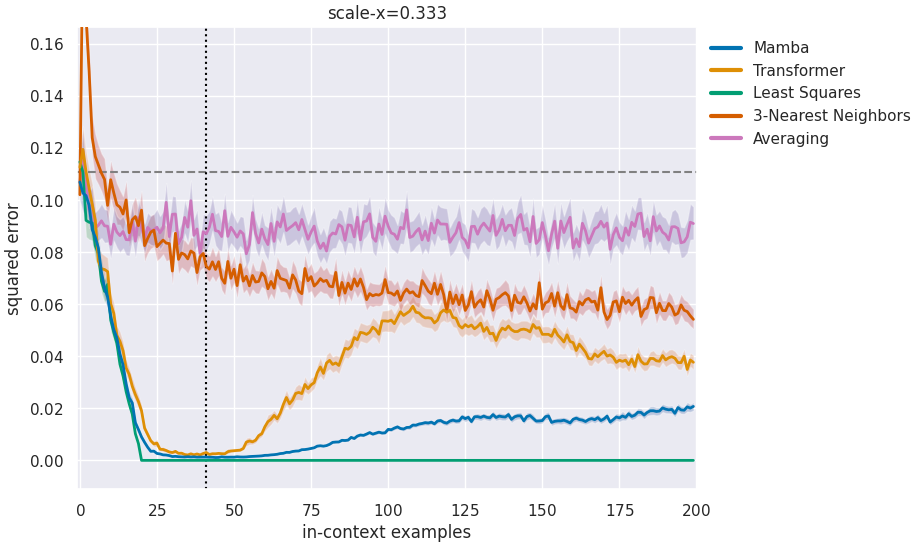

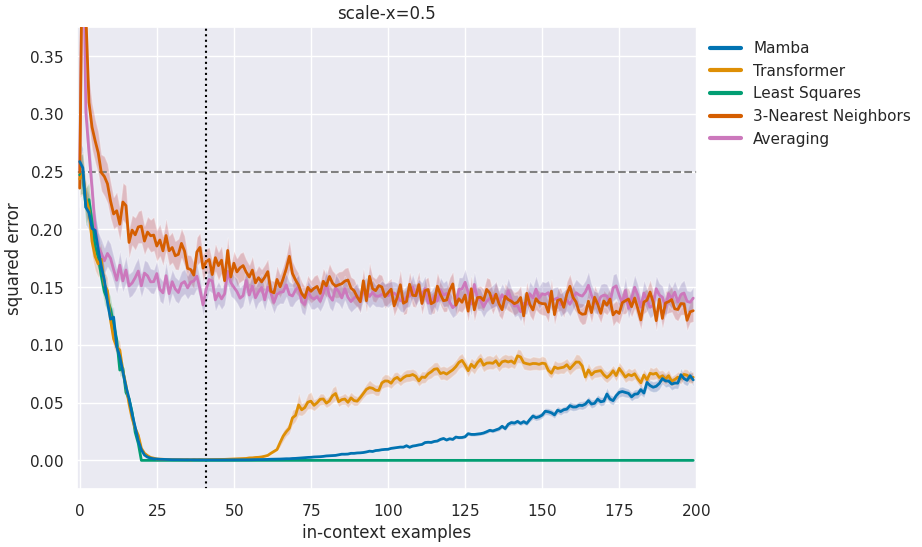

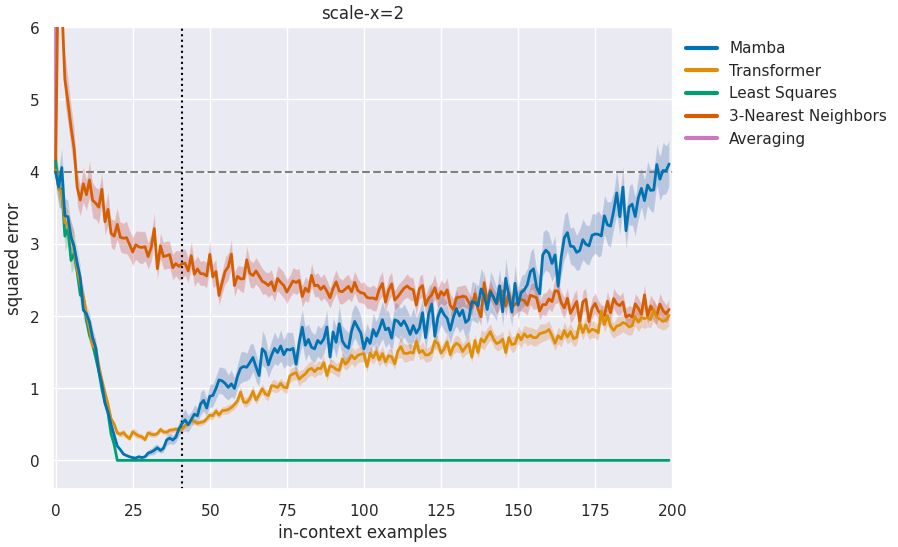

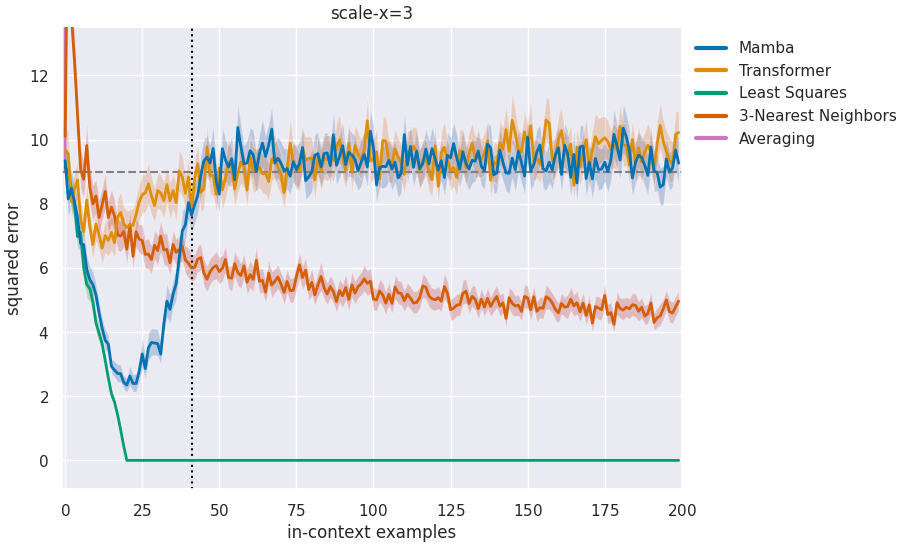

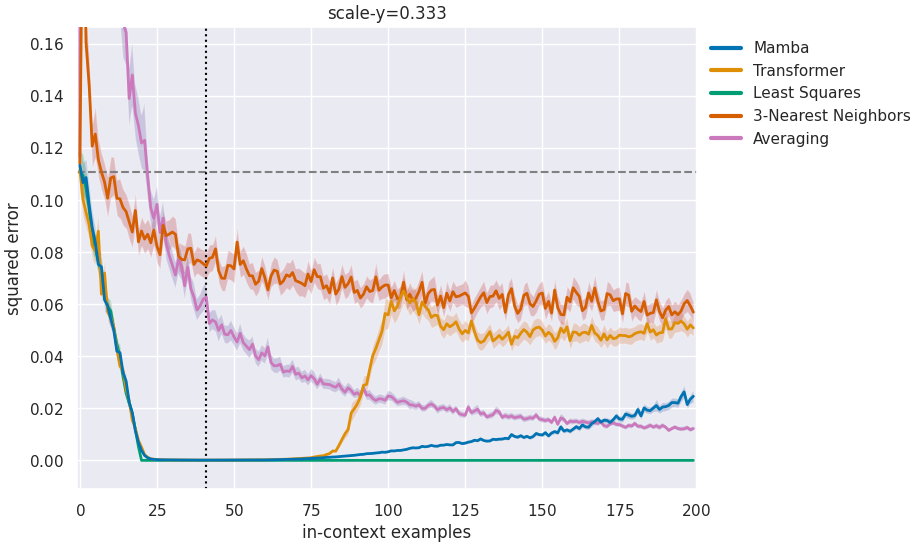

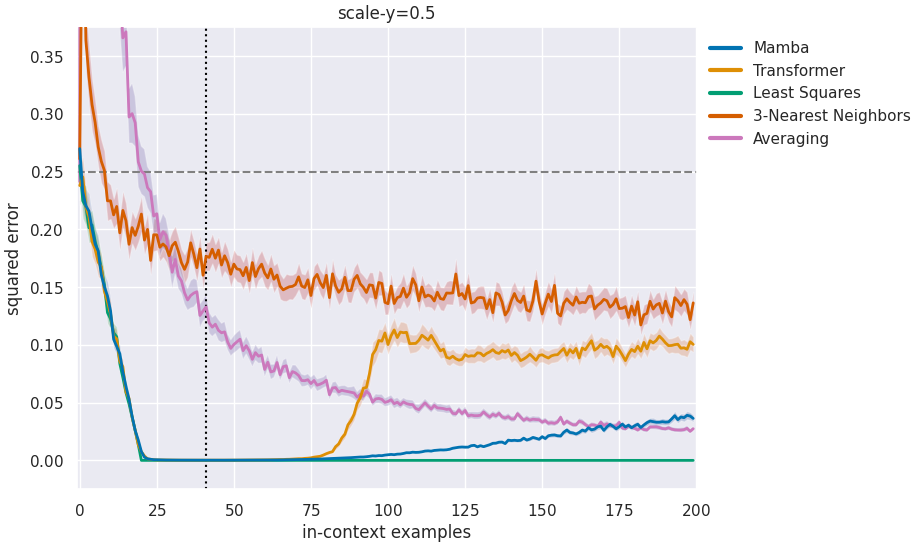

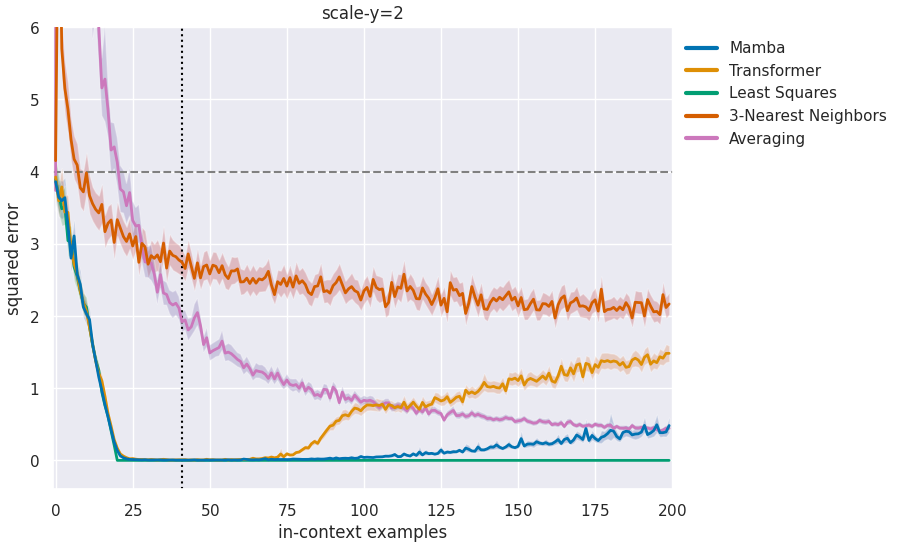

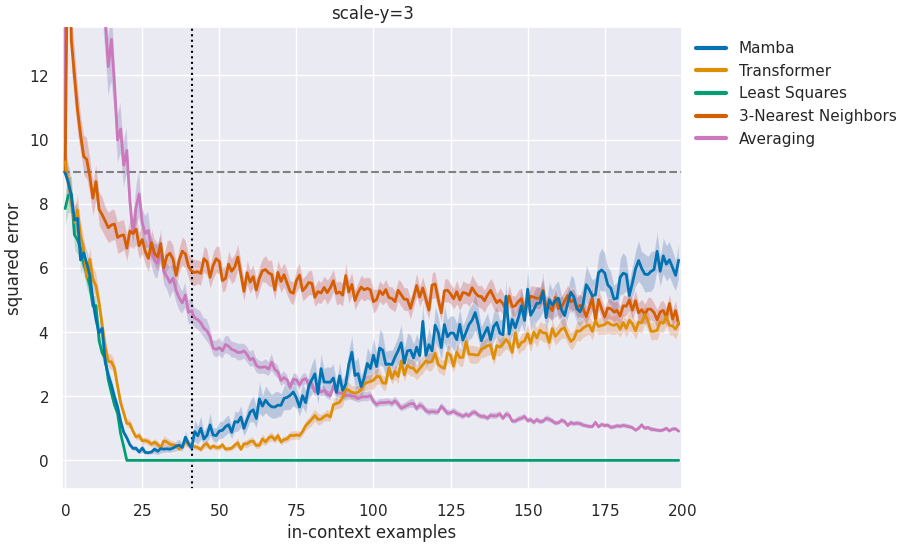

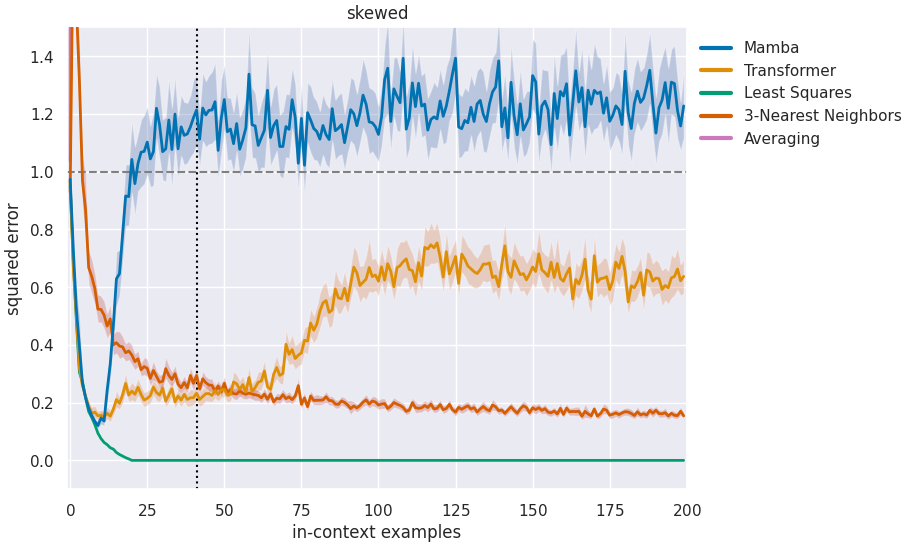

In [28]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale, size_mult=2., n_train_points=n_train_points)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)
    # plt.savefig(f"../imgs/no_pos/out_of_dist/{name}.png")
    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [21]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [22]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [23]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [24]:
with torch.no_grad():
    pred = model(xs, ys)

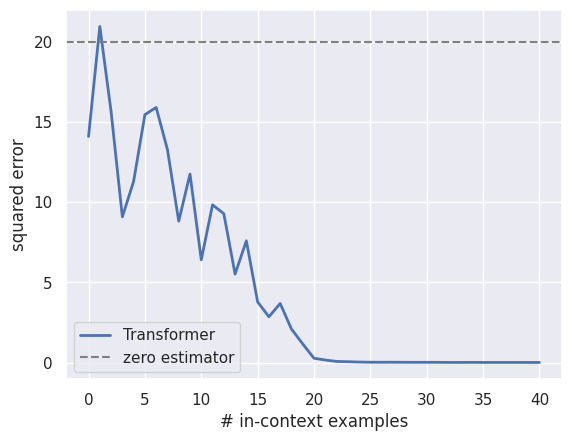

In [25]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [26]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

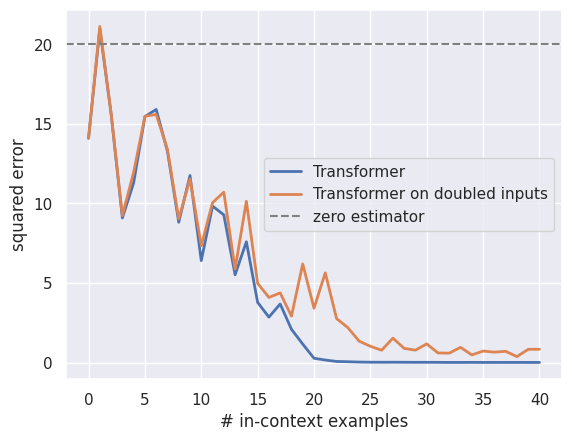

In [27]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.